# Setup hugging face librarys and pipelines

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Setup utility functions

In [4]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding

pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

In [5]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

# custom loss using CV2.Canny() on images
This loss module is used for guidence learning in Unet passes for denoising

In [30]:
import torch
import cv2
import numpy as np

class CannyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output_image):
        # Apply Canny edge detection to the output image
        canny_image = torch.zeros_like(output_image)

        output_np = output_image.detach().cpu().squeeze().numpy()

        output_np = np.transpose(output_np, (1, 2, 0))

        canny_np = cv2.Canny(output_np.astype('uint8'), 100, 200)

        canny_np = np.stack((canny_np,)*3, axis=-1)
        canny_np = np.transpose(canny_np, (2, 0, 1))

        canny_tensor = torch.from_numpy(canny_np).float() / 255.0
        canny_image = canny_tensor.unsqueeze(0)

        # Create target by detaching the canny image
        target = canny_image.detach().to(output_image.device)

        # Compute the mean squared error between the output and target
        loss = torch.mean((output_image - target) ** 2)

        return loss

edge_loss = CannyLoss()

# Generator funcion to generate images using loss guidence

In [7]:
#Generating an image with these modified embeddings

def generate_with_embs_guidence(text_embeddings, text_input, edge_loss, seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50            # Number of denoising steps
    guidance_scale = 8                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1
    loss_scale = 100 



    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        #### ADDITIONAL GUIDANCE ###
        if i%5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            # latents_x0 = latents - sigma * noise_pred
            latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

            # Calculate loss
            loss = edge_loss(denoised_images) * loss_scale
            
            # Occasionally print it out
            if i%10==0:
                print(i, 'loss:', loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2
        
        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    return latents_to_pil(latents)[0]

# Generator funcion to generate images without loss guidence

In [8]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings, text_input, seed):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

# Pil tor Latent & latent to pil conversion functions

In [9]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

model_folder = '/content/gdrive/MyDrive/textual_inversion'

print(f"list of bin models which will be used for textual inversion {os.listdir(model_folder)}")

Mounted at /content/gdrive
list of bin models which will be used for textual inversion ['line-art.bin', 'hitokomoru-style-nao.bin', 'dr-strange.bin', 'moeb-style.bin', 'gta5-artwork.bin']


# Load 5 models for textual inversion
- line-art
- hitokomoru-style-nao
- dr-strange
- moeb-style
- gta5-artwork

prompt we are using is `Master Chief from helo art`. Here we replace `art` token which is `794` with our custom token for that specific art style for textual inversion.

In [18]:
import os
model_bin_name = os.listdir(model_folder)
print(model_bin_name)

['gta5-artwork.bin', 'moeb-style.bin', 'line-art.bin', 'dr-strange.bin', 'hitokomoru-style-nao.bin']


In [19]:
prompt = 'Master Chief from helo art'
print('tokenizer(prompt):', tokenizer(prompt))

tokenizer(prompt): {'input_ids': [49406, 3498, 3455, 633, 919, 334, 794, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:
replace_token = int(794)

manual seeds for all 5 models to generate random latents

In [21]:
manual_seeds = [1000, 2000, 3000, 4000, 5000]

# Function to generate images given the bin model for textual inversion

### Generate image using loss guidence called as `edge loss` which uses Canny edge filter

In [22]:
def generate_art_image_from_bin(bin_model, seed):
  line_art_embed = torch.load(os.path.join(model_folder, bin_model))
  #print unique key containing token for this learned embedding
  key_name = list(line_art_embed.keys())[0]
  print(f"unique name of embedding for art bin {bin_model} is {key_name}")

  # Tokenize
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  input_ids = text_input.input_ids.to(torch_device)

  # Get token embeddings
  token_embeddings = token_emb_layer(input_ids)

  # The new embedding - our special birb word
  replacement_token_embedding = line_art_embed[key_name].to(torch_device)

  # Insert this into the token embeddings
  token_embeddings[0, torch.where(input_ids[0]==replace_token)] = replacement_token_embedding.to(torch_device)

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  # And generate an image with this:
  return generate_with_embs_guidence(modified_output_embeddings, text_input, edge_loss, seed)

### Generate image without using loss guidence

In [23]:
def generate_art_image_from_bin_no_guidence(bin_model, seed):
  line_art_embed = torch.load(os.path.join(model_folder, bin_model))
  #print unique key containing token for this learned embedding
  key_name = list(line_art_embed.keys())[0]
  print(f"unique name of embedding for art bin {bin_model} is {key_name}")

  # Tokenize
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  input_ids = text_input.input_ids.to(torch_device)

  # Get token embeddings
  token_embeddings = token_emb_layer(input_ids)

  # The new embedding - our special birb word
  replacement_token_embedding = line_art_embed[key_name].to(torch_device)

  # Insert this into the token embeddings
  token_embeddings[0, torch.where(input_ids[0]==replace_token)] = replacement_token_embedding.to(torch_device)

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  # And generate an image with this:
  return generate_with_embs(modified_output_embeddings, text_input, seed)

# Image generated using `gta5-artwork.bin` "gta5-artwork" model

#### Image generation with no Canny loss guidence.

unique name of embedding for art bin gta5-artwork.bin is <gta5-artwork>


/tmp/ipykernel_1453468/380596821.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

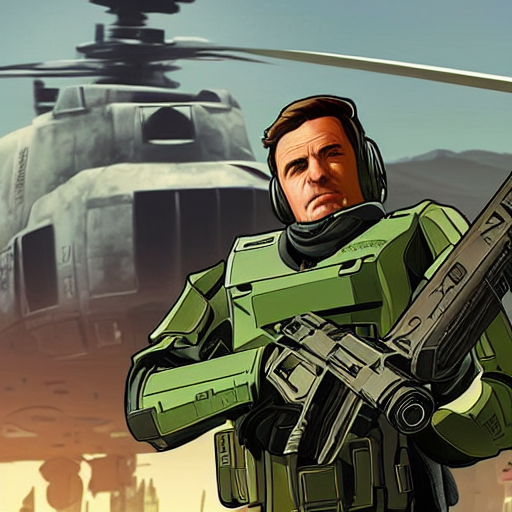

In [47]:
image1 = generate_art_image_from_bin_no_guidence(model_bin_name[0], manual_seeds[0])
image1

#### Image generation with Canny loss guidence.

unique name of embedding for art bin gta5-artwork.bin is <gta5-artwork>


/tmp/ipykernel_1453468/1405002747.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 10.926088333129883
10 loss: 5.391288757324219
20 loss: 3.4788732528686523
30 loss: 3.475769519805908
40 loss: 3.4350879192352295


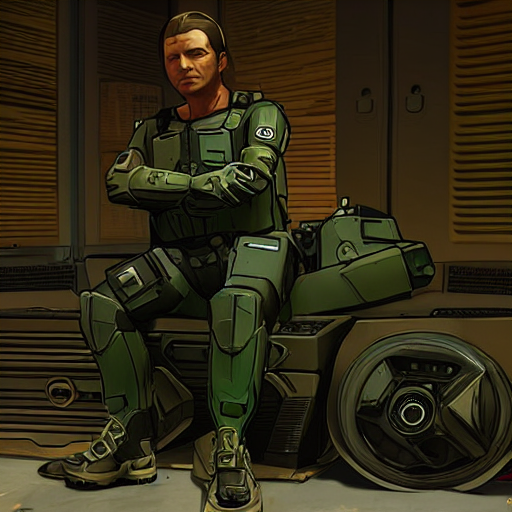

In [48]:
image11 = generate_art_image_from_bin(model_bin_name[0], manual_seeds[0])
image11

# Image generated using `moeb-style.bin` model and same prompt!

#### Image generation with no Canny loss guidence.

unique name of embedding for art bin moeb-style.bin is <moe-bius>


/tmp/ipykernel_1453468/380596821.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

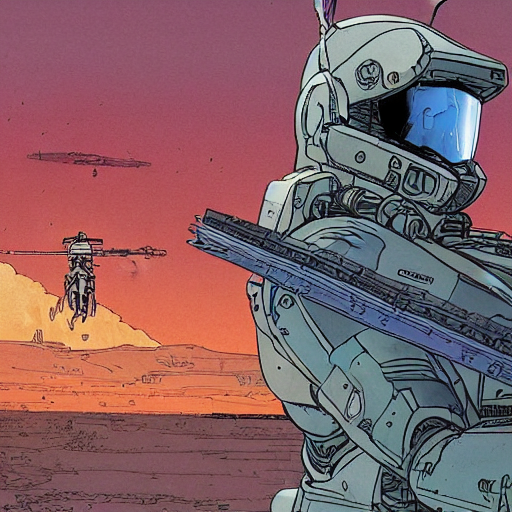

In [49]:
image2 = generate_art_image_from_bin_no_guidence(model_bin_name[1], manual_seeds[1])
image2

#### Image generation with Canny loss guidence.

unique name of embedding for art bin moeb-style.bin is <moe-bius>


/tmp/ipykernel_1453468/1405002747.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 21.572860717773438
10 loss: 6.69619607925415
20 loss: 5.040501594543457
30 loss: 4.472309112548828
40 loss: 4.002780914306641


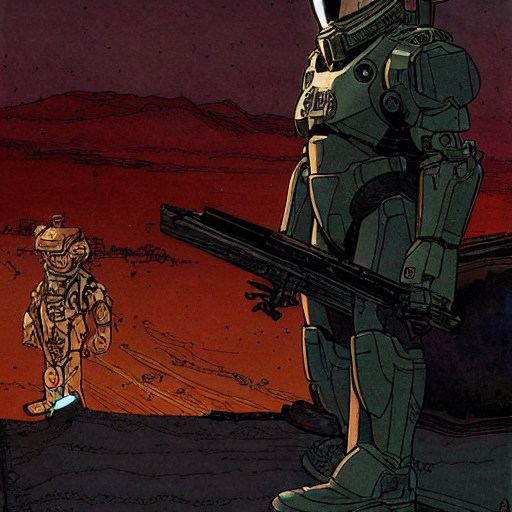

In [50]:
image12 = generate_art_image_from_bin(model_bin_name[1], manual_seeds[1])
image12

# Image generated using `line-art.bin` model and same prompt!


#### Image generation with no Canny loss guidence.

unique name of embedding for art bin line-art.bin is <line-art>


/tmp/ipykernel_1453468/380596821.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

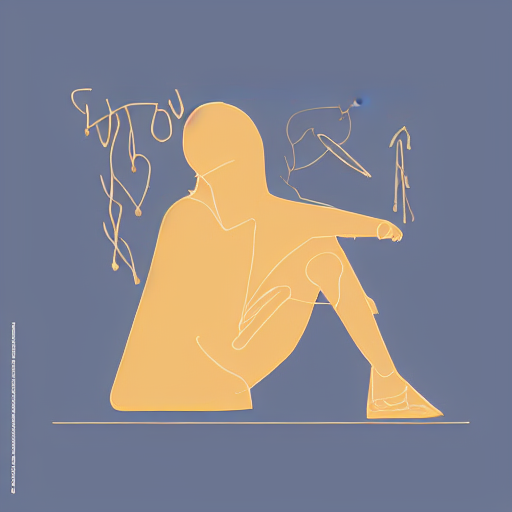

In [51]:
image3 = generate_art_image_from_bin_no_guidence(model_bin_name[2], manual_seeds[2])
image3

#### Image generation with Canny loss guidence.

unique name of embedding for art bin line-art.bin is <line-art>


/tmp/ipykernel_1453468/1405002747.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 46.915706634521484
10 loss: 7.17753791809082
20 loss: 6.705699920654297
30 loss: 6.5787434577941895
40 loss: 6.556311130523682


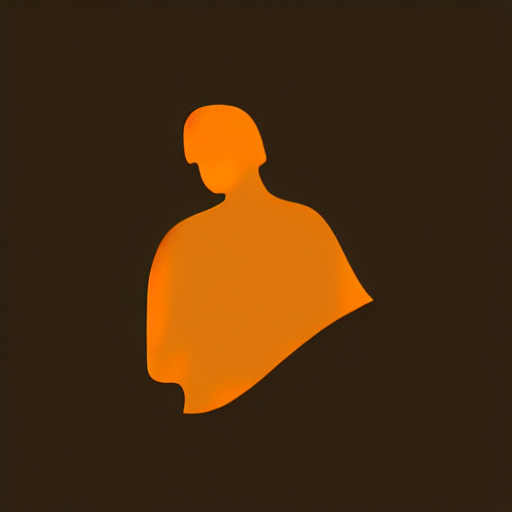

In [52]:
image13 = generate_art_image_from_bin(model_bin_name[2], manual_seeds[2])
image13

# Image generated using `dr-strange.bin` model and same prompt!

#### Image generation with no Canny loss guidence.

unique name of embedding for art bin dr-strange.bin is <dr-strange>


/tmp/ipykernel_1453468/380596821.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

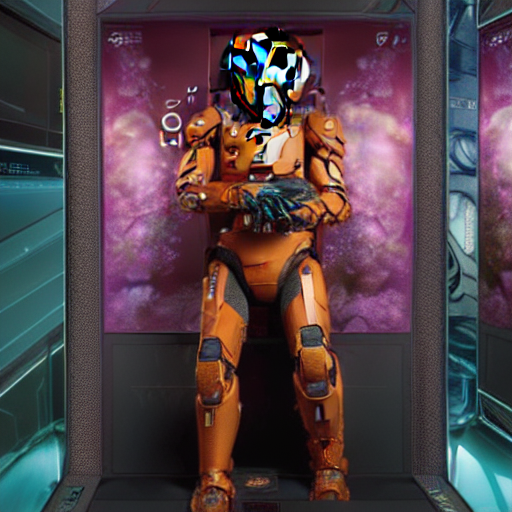

In [53]:
image4 = generate_art_image_from_bin_no_guidence(model_bin_name[3], manual_seeds[3])
image4

#### Image generation with Canny loss guidence.

unique name of embedding for art bin dr-strange.bin is <dr-strange>


/tmp/ipykernel_1453468/1405002747.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 4.011546611785889
10 loss: 2.1936004161834717
20 loss: 5.553413391113281
30 loss: 6.092578887939453
40 loss: 4.484638690948486


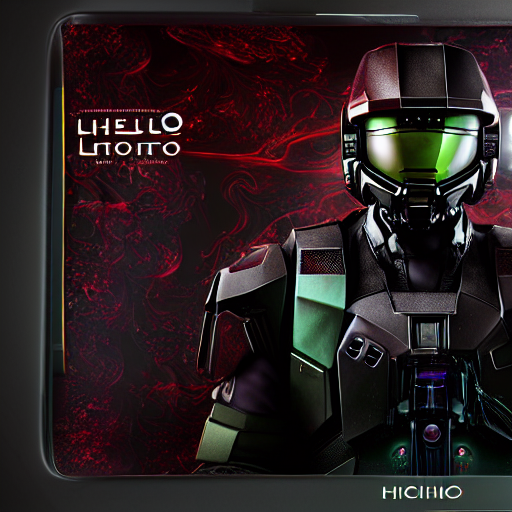

In [54]:
image14 = generate_art_image_from_bin(model_bin_name[3], manual_seeds[3])
image14

# Image generated using `hitokomoru-style-nao.bin` model and same prompt!


#### Image generation with no Canny loss guidence.

unique name of embedding for art bin hitokomoru-style-nao.bin is <hitokomoru-style>


/tmp/ipykernel_1453468/380596821.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

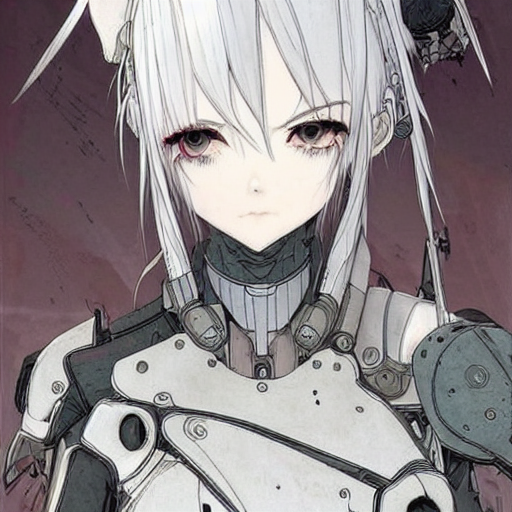

In [55]:
image5 = generate_art_image_from_bin_no_guidence(model_bin_name[4], manual_seeds[4])
image5

#### Image generation with Canny loss guidence.

unique name of embedding for art bin hitokomoru-style-nao.bin is <hitokomoru-style>


/tmp/ipykernel_1453468/1405002747.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

0 loss: 42.36015701293945
10 loss: 8.07673454284668
20 loss: 4.7556633949279785
30 loss: 3.9618678092956543
40 loss: 3.9234917163848877


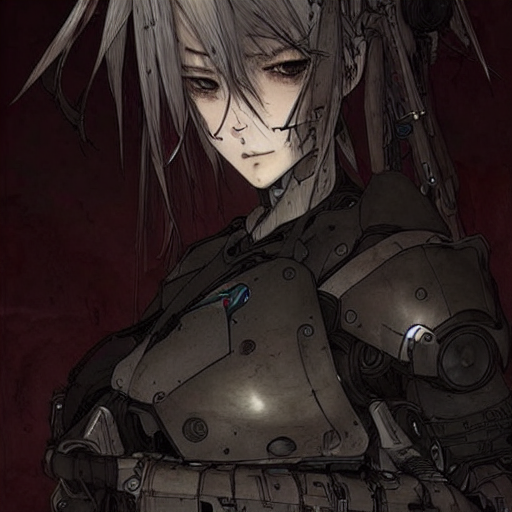

In [56]:
image15 = generate_art_image_from_bin(model_bin_name[4], manual_seeds[4])
image15

# All images together!!

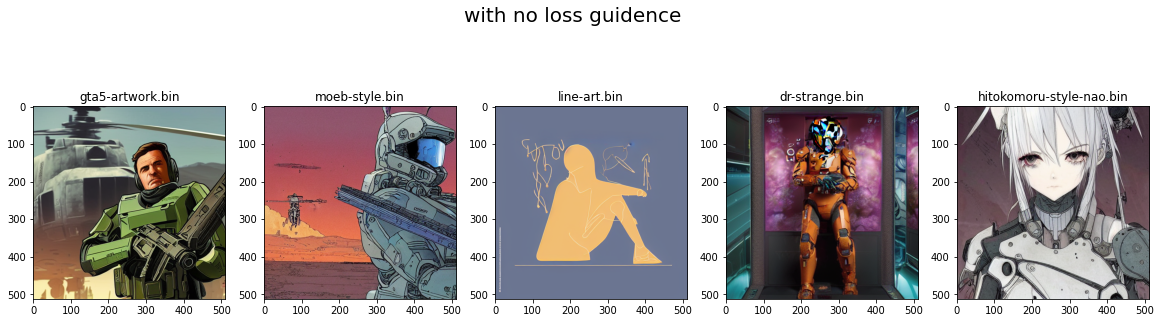

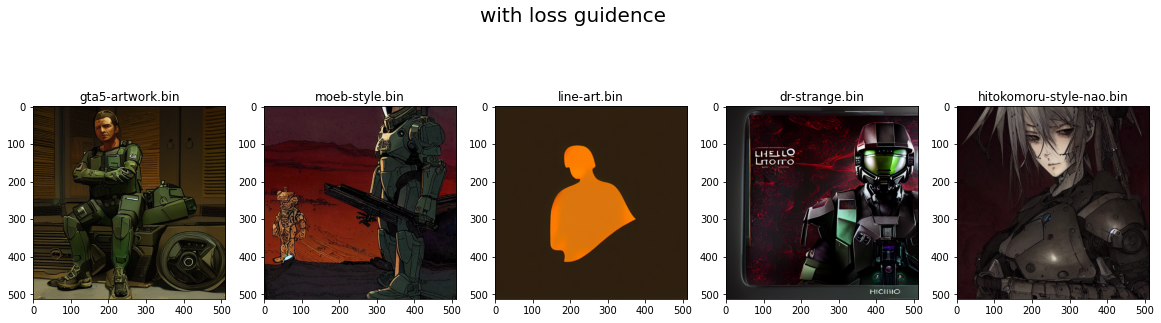

In [57]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np

images_list_no_guide = [image1,image2,image3,image4,image5]
images_list_guide = [image11,image12,image13,image14,image15]

def plot_images(images_list, title):
    images = []
    for img_path in images_list:
        images.append(np.array(img_path))

    plt.figure(figsize=(20,10))
    plt.suptitle(title, fontsize=20)
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), int(columns), i + 1)
        plt.title(model_bin_name[i])
        plt.imshow(image)

plot_images(images_list_no_guide, 'with no loss guidence')
plot_images(images_list_guide, 'with loss guidence')